In [1]:
%load_ext autoreload
%autoreload 2
from manual_log_reg import ManualLogisticRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [2]:
X = pd.read_csv('X_data.csv')
X.drop(columns=X.columns[0], axis=1, inplace=True)
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


In [3]:
y = pd.read_csv('y_data.csv')  # read and convert to numpy
y.drop(columns=y.columns[0], axis=1, inplace=True)
y.head()

,y
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [4]:
X = X.values  # convert to numpy
y = y.values.astype(int).flatten()  # convert to numpy integers and flatten
X = np.concatenate((np.ones((len(y), 1)), X), axis=1) # add bias term

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=336546)

Implement the functions in manual_log_reg.py and train *log_reg* below. Use the *plot* flag in order to show reasonable learning (decrease of the training loss as a function of the iterations). Don't forget to make minor preprocessing so that gradient descent will be stable.

In [89]:
log_reg = ManualLogisticRegression()

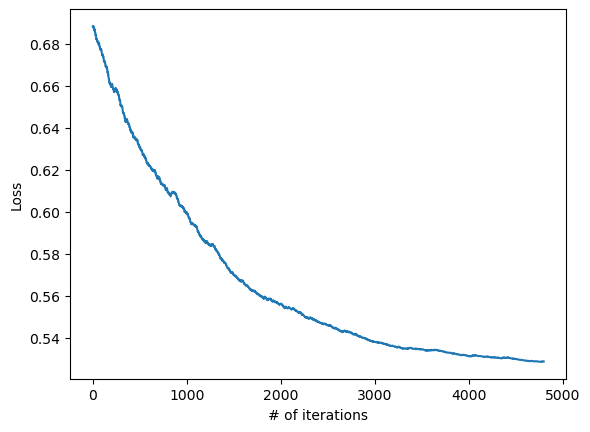

In [90]:
# ------------------------ IMPLEMENT YOUR CODE HERE: ----------------------------------
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

for i in range(1,5): # Outliers removal
    Q1 = np.percentile(X_train[:,i],25)
    Q3 = np.percentile(X_train[:,i],75)
    IQR = Q3 - Q1
    topTh = Q3 + 1.5 * IQR
    bottomTh = Q1 - 1.5 * IQR
    outliers = (X_train[:,i] > topTh) | (X_train[:,i] < bottomTh)
    X_train[:,i][outliers] = np.full((outliers.sum()), np.nan)
    outliers = (X_test[:,i] > topTh) | (X_test[:,i] < bottomTh)
    X_test[:,i][outliers] = np.full((outliers.sum()), np.nan)

imputer = KNNImputer(n_neighbors=5) # Impute nans
X_train[:] = imputer.fit_transform(X_train)
X_test[:] = imputer.transform(X_test)

scaler = RobustScaler() # Noramlize 
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

log_reg.fit(X_train_std,y_train,eta=0.005,plot=True)
# --------------------------------------------------------------------------------------

Sort the learned weights (excluding the bias term). Which of the features is the most important one?

In [93]:
# ------------------------ IMPLEMENT YOUR CODE HERE: ----------------------------------
features = ['Age','Systolic_BP','Diastolic_BP','Cholesterol']
weights = log_reg.w[1:]
sorted = weights.argsort()[::-1]
features_sorted = [features[i] for i in sorted]
for (feature,weight) in zip(features_sorted,weights):
    print(f'{feature} weight = {weight:.3f}')
# --------------------------------------------------------------------------------------

Age weight = 1.195
Systolic_BP weight = 0.849
Cholesterol weight = 0.117
Diastolic_BP weight = 0.576


Report the performance on the "correct dataset" using *conf_matrix* function. The required metrics are: TN, FP, FN, TP, Se, Sp, PPV, NPV, Acc, F1 and AUC. You may use functions seen in the tutorial but notice that one of the metrics can and should be called from *log_reg* itself.

In [96]:
# ------------------------ IMPLEMENT YOUR CODE HERE: ----------------------------------
from sklearn.metrics import roc_auc_score
conf = log_reg.conf_matrix(X_test_std,y_test)
TN = conf[0,0]
FP = conf[0,1]
FN = conf[1,0]
TP = conf[1,1]
Se = TP/(TP+FN)
Sp = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
Acc = log_reg.score(X_test_std,y_test)
F1 = (2*Se*PPV)/(Se+PPV)
y_prob = log_reg.predict_proba(X_test_std)
AUROC = roc_auc_score(y_test, y_prob)

print(f'TN = {TN:3.0f}')
print(f'FP = {FP:3.0f}')
print(f'FN = {FN:3.0f}')
print(f'TP = {TP:3.0f}')
print(f'Sensitivity = {Se:.3f}')
print(f'Specificity = {Sp:.3f}')
print(f'PPV = {PPV:.3f}')
print(f'NPV = {NPV:.3f}')
print(f'Accuracy = {Acc:.3f}')
print(f'F1 = {F1:.3f}')
print(f'AUROC = {AUROC:.3f}')
# --------------------------------------------------------------------------------------

TN = 433
FP = 151
FN = 164
TP = 452
Sensitivity = 0.734
Specificity = 0.741
PPV = 0.750
NPV = 0.725
Accuracy = 0.738
F1 = 0.742
AUROC = 0.807


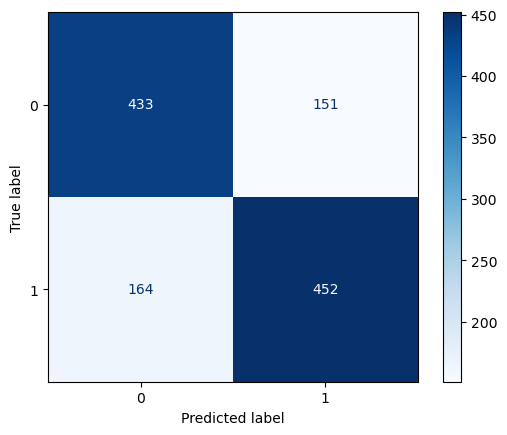

In [95]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test,log_reg.predict(X_test_std),cmap=plt.cm.Blues)